In [252]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [253]:
file_path = 'data/Airbnb_Open_Data.csv' 
important_columns = [
    'host_identity_verified', 'neighbourhood group', 'neighbourhood', 'lat',
    'long', 'room type', 'price', 'service fee', 'minimum nights', 'number of reviews', 'reviews per month', 'availability 365'
]
df = pd.read_csv(file_path, usecols=important_columns, low_memory=False)

# Check for data types
print("Data Types:")
print(df.dtypes)

Data Types:
host_identity_verified     object
neighbourhood group        object
neighbourhood              object
lat                       float64
long                      float64
room type                  object
price                      object
service fee                object
minimum nights            float64
number of reviews         float64
reviews per month         float64
availability 365          float64
dtype: object


In [234]:
# Check for duplicates
duplicates = df.duplicated().sum()
print("\nNumber of Duplicate Rows: ", duplicates)
df = df.drop_duplicates()
df.head()


Number of Duplicate Rows:  16993


,host_identity_verified,neighbourhood group,neighbourhood,lat,long,room type,price,service fee,minimum nights,number of reviews,reviews per month,availability 365
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,Private room,$966,$193,10.0,9.0,0.21,286.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,$142,$28,30.0,45.0,0.38,228.0
2,NaN,Manhattan,Harlem,40.80902,-73.94190,Private room,$620,$124,3.0,0.0,NaN,352.0
3,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,$368,$74,30.0,270.0,4.64,322.0
4,verified,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,$204,$41,10.0,9.0,0.10,289.0


In [235]:
#get unique neighbourhoods 
unique_neighbourhoods = df['neighbourhood group'].unique()

# Print unique values
print("Unique neighbourhood groups:")
print(unique_neighbourhoods)

Unique neighbourhood groups:
['Brooklyn' 'Manhattan' 'brookln' 'manhatan' 'Queens' nan 'Staten Island'
 'Bronx']


In [236]:
# Replace incorrect spellings with correct ones
df['neighbourhood group'] = df['neighbourhood group'].replace({
    'brookln': 'Brooklyn',
    'manhatan': 'Manhattan'
})


In [237]:
# Replace NaN in 'host_identity_verified' with 'unconfirmed'
df.loc[df['host_identity_verified'].isnull(), 'host_identity_verified'] = 'unconfirmed'

# Replace NaN in 'reviews per month' with 0 
df.loc[df['reviews per month'].isnull(), 'reviews per month'] = 0

# Drop rows where 'neighbourhood group' is NaN
df.dropna(subset=['neighbourhood group'], inplace=True)

In [238]:
df.head()

,host_identity_verified,neighbourhood group,neighbourhood,lat,long,room type,price,service fee,minimum nights,number of reviews,reviews per month,availability 365
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,Private room,$966,$193,10.0,9.0,0.21,286.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,$142,$28,30.0,45.0,0.38,228.0
2,unconfirmed,Manhattan,Harlem,40.80902,-73.94190,Private room,$620,$124,3.0,0.0,0.00,352.0
3,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,$368,$74,30.0,270.0,4.64,322.0
4,verified,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,$204,$41,10.0,9.0,0.10,289.0


In [239]:
# convert price and service fee to float numbers , because it includes $ sign and it is not numberic 
def convert_price_and_service_fee_to_numeric(value):
    try:
        # remove $ and deal with text values 
        cleaned_value = float(''.join(filter(str.isdigit, str(value))))
        return cleaned_value
    except ValueError:
        return 0  # Return 0 if it can not be converted to float 


df.loc[:, 'price'] = df['price'].apply(clean_and_convert_to_numeric)
df.loc[:, 'service fee'] = df['service fee'].apply(clean_and_convert_to_numeric)

In [240]:
df.head()

,host_identity_verified,neighbourhood group,neighbourhood,lat,long,room type,price,service fee,minimum nights,number of reviews,reviews per month,availability 365
0,unconfirmed,Brooklyn,Kensington,40.64749,-73.97237,Private room,966.0,193.0,10.0,9.0,0.21,286.0
1,verified,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,142.0,28.0,30.0,45.0,0.38,228.0
2,unconfirmed,Manhattan,Harlem,40.80902,-73.94190,Private room,620.0,124.0,3.0,0.0,0.00,352.0
3,unconfirmed,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,368.0,74.0,30.0,270.0,4.64,322.0
4,verified,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,204.0,41.0,10.0,9.0,0.10,289.0


In [241]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['service fee'] = pd.to_numeric(df['service fee'], errors='coerce')
# remove where price is zero and where availability 365 is negative or greater than 365
df = df[(df['price'] != 0) & (df['availability 365'] >= 0) & (df['availability 365'] <= 365)]
print("Summary Statistics for Numeric Columns:")
df.describe()

Summary Statistics for Numeric Columns:


,lat,long,price,service fee,minimum nights,number of reviews,reviews per month,availability 365
count,81946.000000,81946.000000,81954.000000,81954.000000,81616.000000,81843.000000,81954.000000,81954.000000
mean,40.728054,-73.949246,625.044549,124.637772,8.390169,27.713525,1.180156,139.592723
std,0.055941,0.050105,331.855301,66.605943,30.625378,50.708340,1.701028,129.780914
min,40.499790,-74.249840,50.000000,0.000000,-1223.000000,0.000000,0.000000,0.000000
25%,40.688630,-73.982630,339.000000,67.000000,2.000000,1.000000,0.100000,7.000000
50%,40.722380,-73.954400,625.000000,125.000000,3.000000,7.000000,0.510000,101.000000
75%,40.762720,-73.931850,913.000000,182.000000,5.000000,30.000000,1.740000,262.000000
max,40.916970,-73.705220,1200.000000,240.000000,5645.000000,1024.000000,90.000000,365.000000


C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


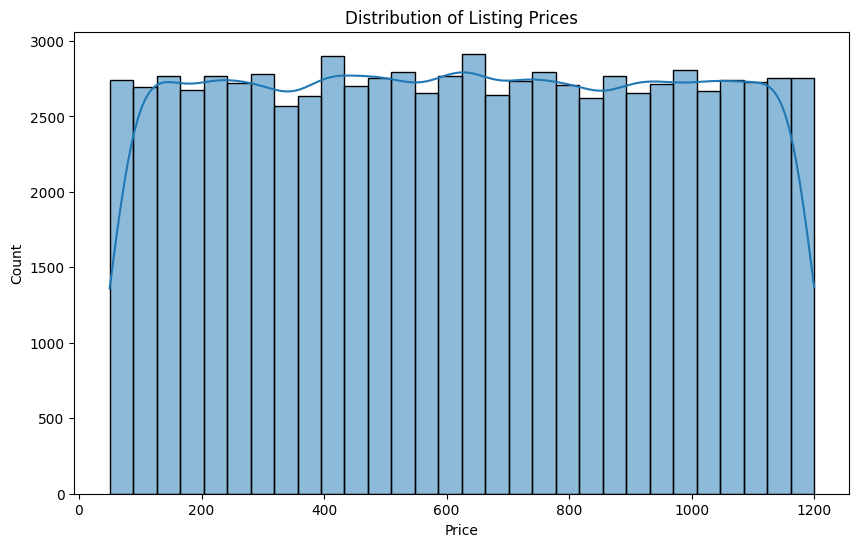

In [200]:
# distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribution of Listing Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


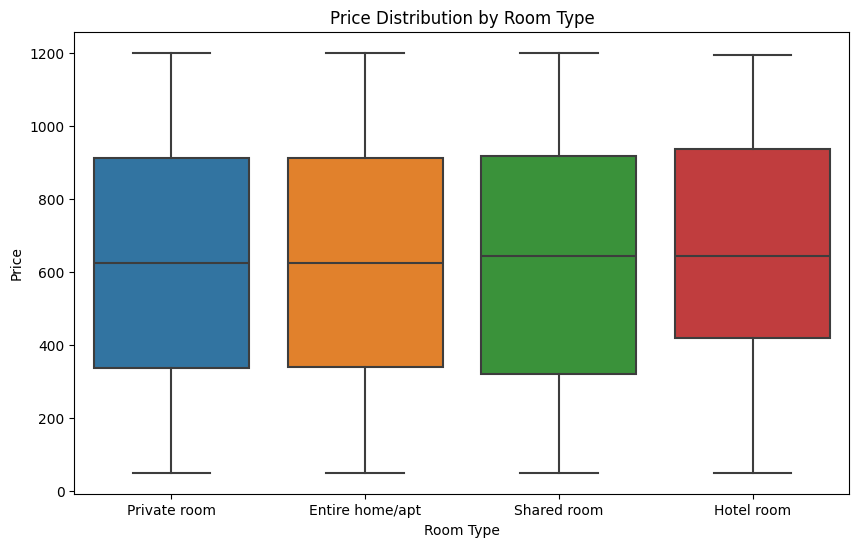

In [201]:
# Boxplot of prices by room type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room type', y='price', data=df)
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()


C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


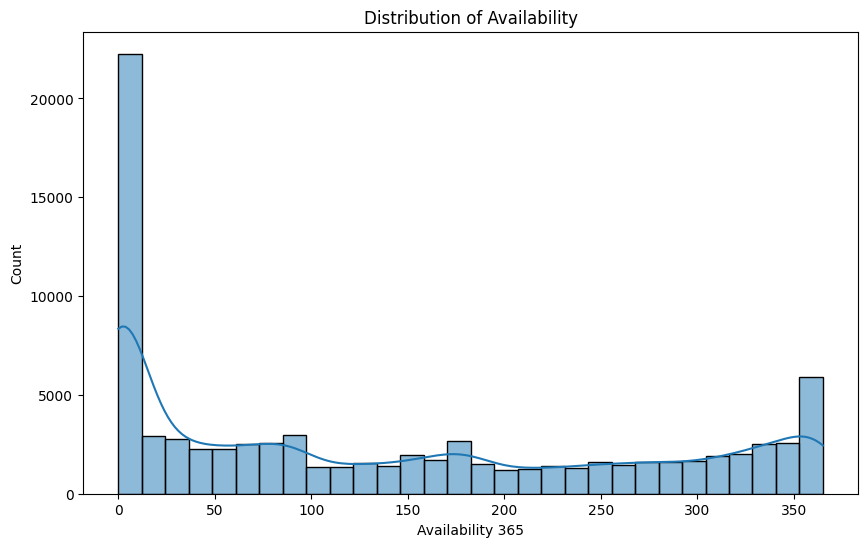

In [202]:
#Distribution of availability 365
plt.figure(figsize=(10, 6))
sns.histplot(df['availability 365'], bins=30, kde=True)
plt.title('Distribution of Availability')
plt.xlabel('Availability 365')
plt.ylabel('Count')
plt.show()


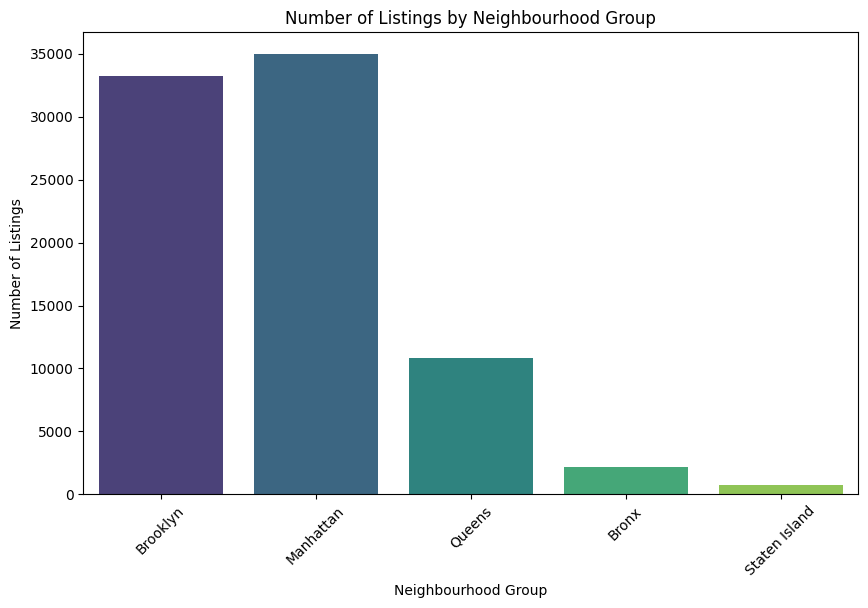

In [203]:
#Bar plot of listing counts by neighbourhood group
plt.figure(figsize=(10, 6))
sns.countplot(x='neighbourhood group', data=df, palette='viridis')
plt.title('Number of Listings by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()


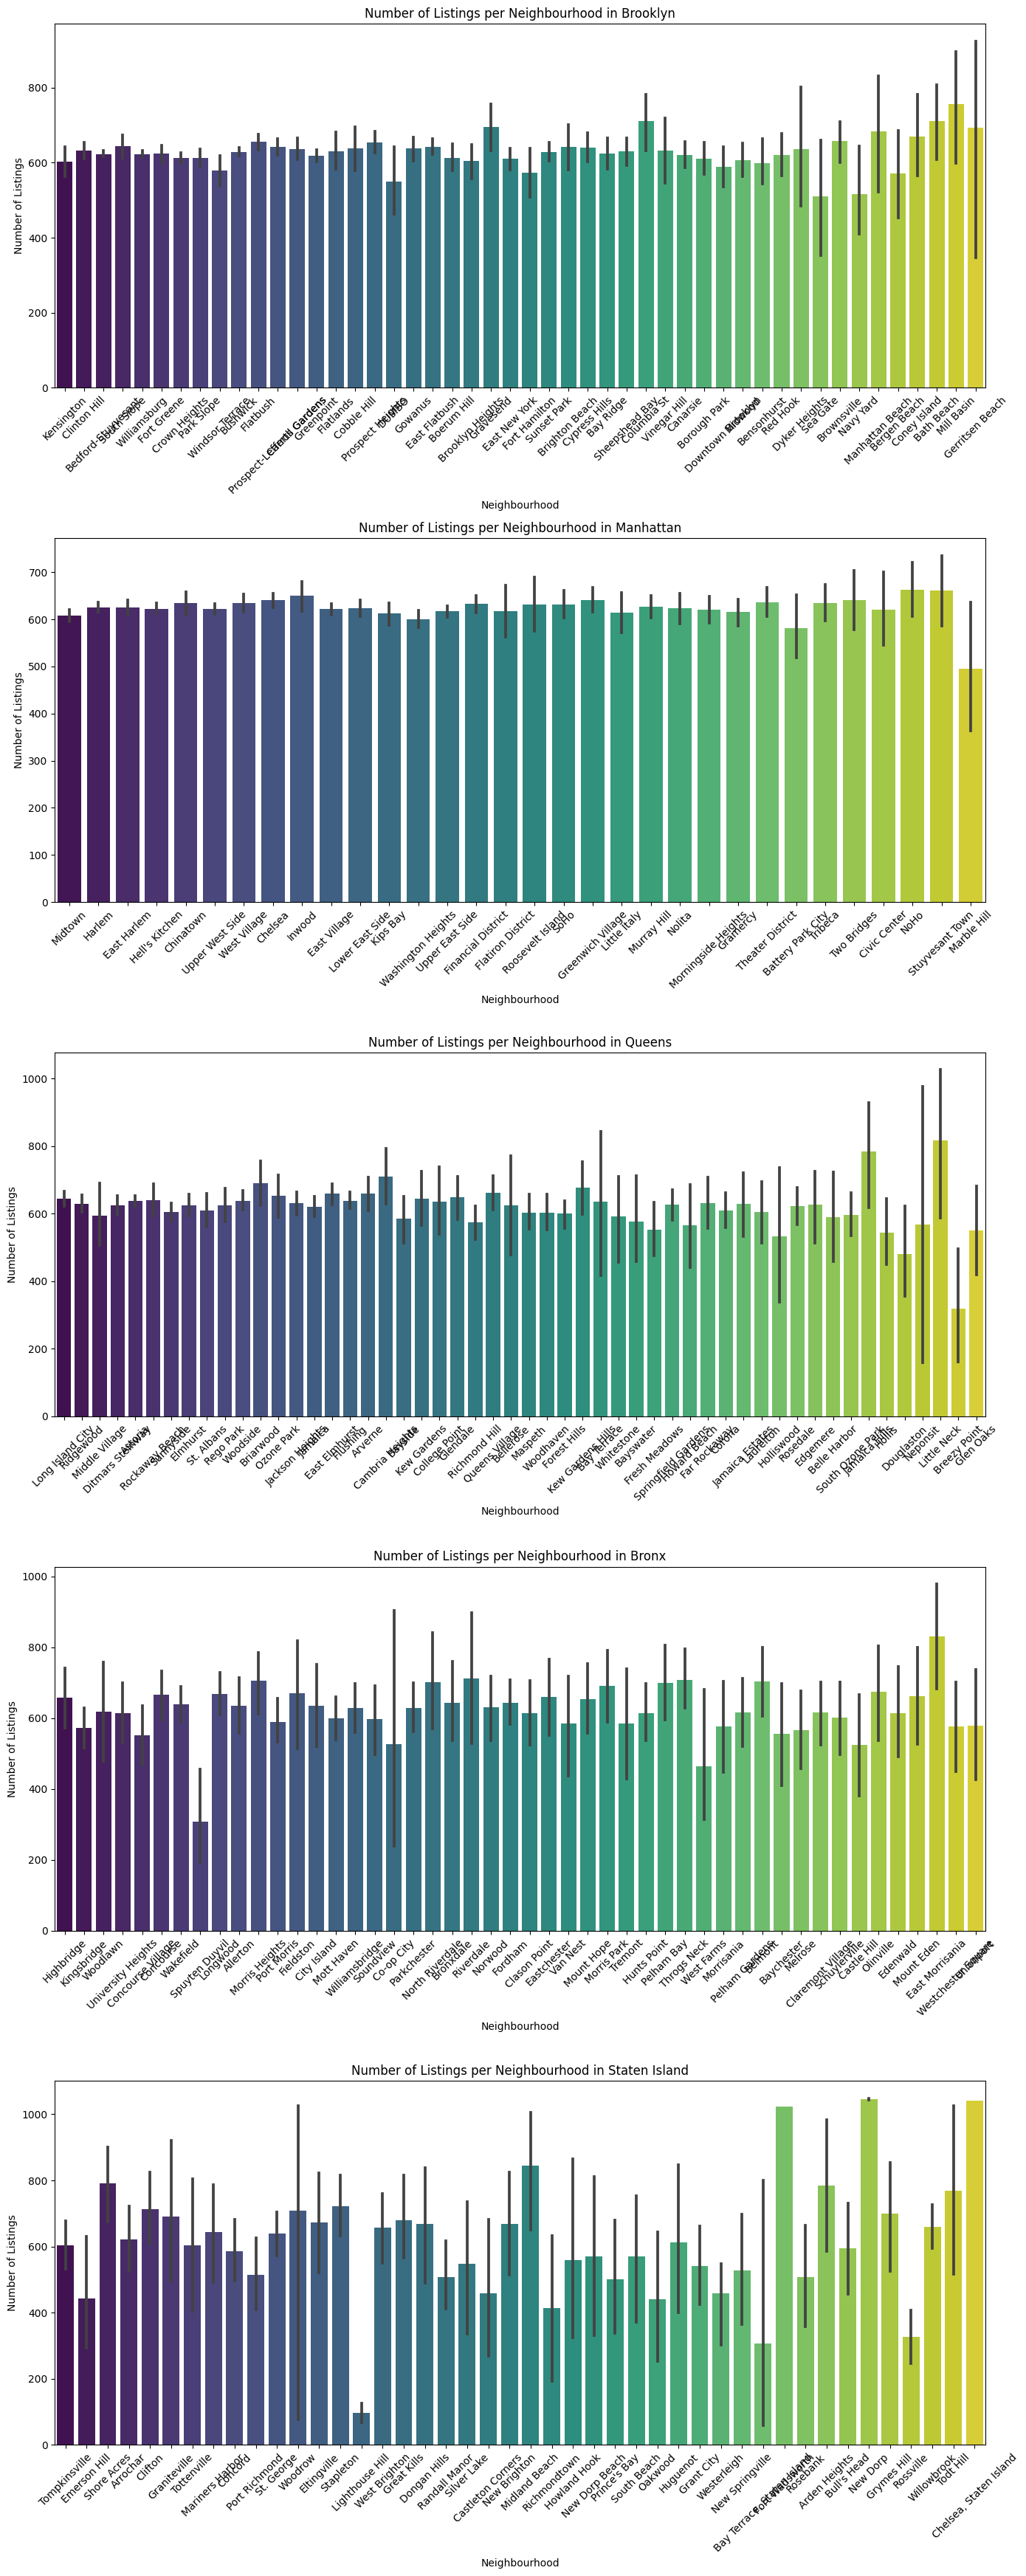

In [213]:
unique_neighbourhood_groups = df['neighbourhood group'].unique()

# Plotting Number of Listings per Neighbourhood for each Neighbourhood Group
plt.figure(figsize=(14, 35))

for i, group in enumerate(unique_neighbourhood_groups, start=1):
    plt.subplot(len(unique_neighbourhood_groups), 1, i)
    group_data = df[df['neighbourhood group'] == group]
    sns.barplot(x='neighbourhood', y='price', data=group_data, palette='viridis')
    plt.title(f'Number of Listings per Neighbourhood in {group}')
    plt.xlabel('Neighbourhood')
    plt.ylabel('Number of Listings')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()